In [3]:
import opendatasets as od
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET
import os
import cv2
import random
import itertools
from glob import glob
from collections import Counter
from skimage.feature import hog
from skimage import exposure
from PIL import Image
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [4]:
def extract_numeric_part(filename):
    """
    extract_numeric_part helps to sort the files by extracting
    the numerical part so it can be sorted
    :param filename: filename of the folder. Has to contain "/" and not "\"
    :return: digits of the filename
    """ 
    filename = filename.split('/')
    return int(''.join(filter(str.isdigit, filename[-1])))


annotations_horizontal_boxes = os.listdir('military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/')
annotations_oriented_boxes = os.listdir("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/")
images = os.listdir("military-aircraft-recognition-dataset/JPEGImages/")
print(f"Total amount of files in Horizontal Bounding Boxes:{len(annotations_horizontal_boxes)}")
print(f"Total amount of files in Oriented Bounding Boxes:{len(annotations_oriented_boxes)}")
print(f"Total amount of files in JPEGImages:{len(images)}")
                    
annotations_horizontal_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Horizontal Bounding Boxes/*.xml"), key=extract_numeric_part)
annotations_oriented_boxes = sorted(glob("military-aircraft-recognition-dataset/Annotations/Oriented Bounding Boxes/*.xml"), key=extract_numeric_part)
images = sorted(glob("military-aircraft-recognition-dataset/JPEGImages/*.jpg"), key=extract_numeric_part)

print(f"XML files in Horizontal Bounding Boxes:{len(annotations_horizontal_boxes)}")
print(f"XML files in Oriented Bounding Boxes:{len(annotations_oriented_boxes)}")
print(f"JPG files in JPEGImages:{len(annotations_oriented_boxes)}")

Total amount of files in Horizontal Bounding Boxes:3842
Total amount of files in Oriented Bounding Boxes:3842
Total amount of files in JPEGImages:3842
XML files in Horizontal Bounding Boxes:3842
XML files in Oriented Bounding Boxes:3842
JPG files in JPEGImages:3842


In [5]:
def extract_obj(img_list, xml_list):
    """
    extract_obj crops out the planes out of picture
    and helps form the whole dataset
    :param img_list: list of paths of pictures
    :param xml_list: list of paths of xml files-notations(Horizontal Bounding Boxes)
    :return: list of tuple label(type of plane),image(array of pixels)
    """ 
    assert len(img_list) == len(xml_list), "length of image list needs to be equal to length of xml list"
    dataset = []
    for i in range(len(img_list)):
        
        image = cv2.imread(img_list[i]) 
        xml_file = xml_list[i]

        with open(xml_file, 'r') as file:
            tree = ET.parse(file)
            root = tree.getroot()
            for object_element in root.findall('.//object'):
                name_element = object_element.find('name')
                robndbox_element = object_element.find('bndbox')

                if name_element is not None and robndbox_element is not None:
                    label = name_element.text

                    x_left_bottom = int(robndbox_element.find('xmin').text)
                    y_left_bottom = int(robndbox_element.find('ymin').text)
                    x_right_top = int(robndbox_element.find('xmax').text)
                    y_right_top = int(robndbox_element.find('ymax').text)

                    cropped_image = image[(y_left_bottom):(y_right_top), (x_left_bottom):(x_right_top)]

                    dataset.append((label,cropped_image))
    return dataset

In [6]:
dataset = extract_obj(images, annotations_horizontal_boxes)

In [7]:
X_dataset = [dataset[i][1] for i in range(len(dataset))]
Y_dataset = [dataset[i][0] for i in range(len(dataset))]


In [8]:
def extract_file_distribution(distribution_path, annotations_horizontal_boxes, images):
    """
    extract_file_distribution gets type and image of all the planes from distribution
    by counting them from each xml file and extracting from images
    :param distribution_path: path of the distribution file that countains
    numbers of image files 
    :param annotations_horizontal_boxes: path of the xml files folder
    :param images: path of images files folder
    :return: list of tuple label(type of plane),image(array of pixels) of current distribution
    """ 
    with open(distribution_path, 'r') as file:
        numbers = [int(line.strip()) for line in file]
        img_list = [images[number-1] for number in numbers]
        xml_list = [annotations_horizontal_boxes[number-1] for number in numbers]
        
    return extract_obj(img_list, xml_list)

In [9]:
train_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/train.txt'
test_txt_path = 'military-aircraft-recognition-dataset/ImageSets/Main/test.txt'

train_dataset = extract_file_distribution(train_txt_path, annotations_horizontal_boxes, images)
test_dataset = extract_file_distribution(test_txt_path, annotations_horizontal_boxes, images)


train_names = [train_dataset[i][0] for i in range(len(train_dataset))]
train_images = [train_dataset[i][1] for i in range(len(train_dataset))]
test_names = [test_dataset[i][0] for i in range(len(test_dataset))]
test_images = [test_dataset[i][1] for i in range(len(test_dataset))]

In [16]:
test_counter = Counter(test_names)

types = list(test_counter.keys())

In [11]:
# Y_train,Y_test = test_names,train_names
# X_train,X_test = test_images,train_images

#lets experiment and mix all data together and then split it
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset, Y_dataset, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

22341
18095
18095
2011
2011
2235
2235


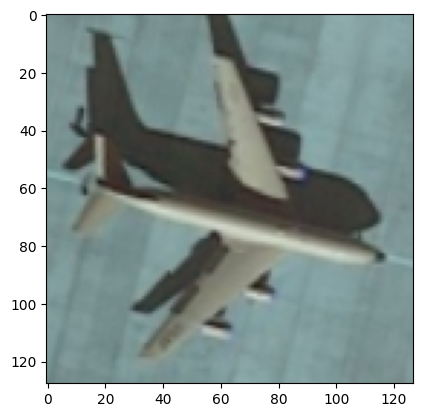

In [12]:
print(len(dataset))
print(len(X_train))
print(len(Y_train))
print(len(X_val))
print(len(Y_val))
print(len(X_test))
print(len(Y_test))
plt.imshow(X_train[0])


In [13]:
from PIL import Image
import numpy as np

def pad_img(img):
    '''
    pad_img transforms an image to the desired size.
    If squared, the image remains the same in ratio;
    if rectangular, it'll be padded evenly to become a squared one.

    :param img: A NumPy array representing the input image.
    :return: A NumPy array representing the transformed image.
    '''

    # Get the dimensions of the image
    old_size = img.shape[1], img.shape[0]
    # Define the desired size to transform the image to
    desired_size = (64, 64)

    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)

    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))

    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2

    # Paste the original image onto the padded image at the calculated position
    padded.paste(Image.fromarray(img), (x, y))

    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)
    # Convert the result back to a NumPy array
    out_img = np.array(out_img)

    # Return the transformed image as a NumPy array
    return out_img


In [14]:
X_train = [pad_img(X_train[i]) for i in range(len(X_train))]
X_test = [pad_img(X_test[i]) for i in range(len(X_test))]
X_val = [pad_img(X_val[i]) for i in range(len(X_val))]

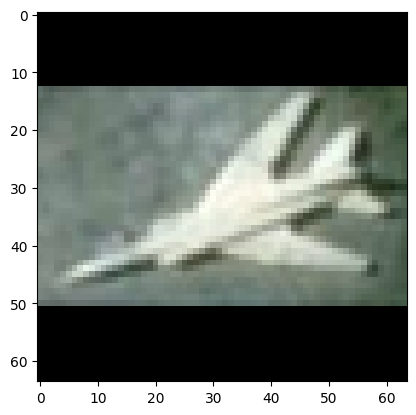

In [15]:
plt.imshow(X_val[1])

In [17]:
categories = types

# Create a LabelBinarizer
label_binarizer = LabelBinarizer()
label_binarizer.fit(categories)

# Transform your dataset into one-hot encoded vectors
Y_train_encoded = label_binarizer.transform(Y_train)
Y_test_encoded = label_binarizer.transform(Y_test)
Y_val_encoded = label_binarizer.transform(Y_val)


In [10]:
def extract_hog_features(image):
    # Compute HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), block_norm='L2-Hys',
                              visualize=True, multichannel=True)
    return hog_image


In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

X_train_normalized = X_train / 255.0
X_val_normalized = X_val/ 255.0
X_test_normalized = X_test/ 255.0


X_train_filtered = np.array([extract_hog_features(img) for img in X_train_normalized if img.ndim == 3])
X_val_filtered = np.array([extract_hog_features(img) for img in X_val_normalized if img.ndim == 3])
X_test_filtered = np.array([extract_hog_features(img) for img in X_test_normalized if img.ndim == 3])

